## Objective
Make sure that model's saved outputs are from the correct model and correct recording

In [1]:
%load_ext autoreload
%autoreload

import sys
PATH = "/data/MEAprojects/DLSpikeSorter"
if PATH not in sys.path:
    sys.path.append(PATH)

# Imports
import numpy as np
import torch
import matplotlib.pyplot as plt
from src.model import ModelSpikeSorter
from pathlib import Path

from src.plot import set_ticks
from src.utils import random_seed

# from importlib import reload
# from src.analysis import standardize
# reload(standardize)
%autoreload 2
from src.analysis.recording import Recording

In [2]:
# Load model and recording
# REC_NAME = 5118
# MODEL_PATH = f"/data/MEAprojects/DLSpikeSorter/models/v0_4_4/{REC_NAME}/230101_135307_305876"
# ##
# recording = Recording(f"/data/MEAprojects/DLSpikeSorter/{REC_NAME}/data.raw.h5", freq_min=300, freq_max=6000)
# model = ModelSpikeSorter.load(MODEL_PATH)

recording = Recording("/data/MEAprojects/dandi/000034/sub-mouse412804/sub-mouse412804_ecephys.nwb", freq_min=300, freq_max=6000)
model = ModelSpikeSorter.load("/data/MEAprojects/DLSpikeSorter/models/v0_4_4/5118/230101_135307_305876")

/home/mea/anaconda3/envs/dl_env/lib/python3.8/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/mea/anaconda3/envs/dl_env/lib/python3.8/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/mea/anaconda3/envs/dl_env/lib/python3.8/site-packages/pynwb/ecephys.py:90: UserWarning: ElectricalSeries 'ElectricalSeries': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


In [4]:
# Load windows and model's outputs
WINDOW_SIZE = 200
WINDOW_STRIDE = 120
NUM_CHANNELS = len(recording.get_channel_locations())
# REC_WINDOWS_PATH = f"/data/MEAprojects/DLSpikeSorter/{REC_NAME}/windows_200_{WINDOW_STRIDE}.npy"
# MODEL_OUTPUTS_PATH = Path(MODEL_PATH) / f"log/windows_200_{WINDOW_STRIDE}_outputs.npy"
REC_WINDOWS_PATH = f"/data/MEAprojects/dandi/000034/sub-mouse412804/dl_spike_sorter/windows_{WINDOW_SIZE}_{WINDOW_STRIDE}.npy"
MODEL_OUTPUTS_PATH = f"/data/MEAprojects/dandi/000034/sub-mouse412804/dl_spike_sorter/windows_{WINDOW_SIZE}_{WINDOW_STRIDE}_outputs.npy"
##
class RecordingWindows:
    """Class to represent windows fed into model of a recording and model's outputs"""
    def __init__(self, stride, num_channels, windows_path,
                 outputs_path):
        self.stride = stride
        self.num_chans = num_channels
        self.windows = np.load(windows_path, mmap_mode="r")
        self.outputs = np.load(outputs_path, mmap_mode="r")
        self.size_windows = self.windows.shape[-1]  # Size of windows
        self.size_outputs = self.outputs.shape[-1]  # Size of outputs

    def plot_window_output(self, idx, title=None,
                           subplots=None):
        # Plot window and model's output

        # Get data
        window = self.windows[idx].flatten()
        window -= np.mean(window)
        output = self.outputs[idx]

        # Set up plots
        if subplots is None:
            fig, (a0, a1) = plt.subplots(2, figsize=(6, 4))
        else:
            fig, a0, a1 = subplots
        axes = a0, a1
        for a in axes:
            a.set_xlim(0, self.size_windows)
        set_ticks(axes, window)

        if title is not None:
            a0.set_title(title)

        # Plot trace
        a0.plot(window)

        # Plot model's output
        output = torch.tensor(output)
        model.plot_loc_probs(output, a1)
        a1.set_title("")

        if subplots is None:
            plt.show()

    def time_to_window(self, time, chan_idx):
        """
        Find i such that self.windows[i] contains :param time: within the model output region
        on the channel :param chan_idx:

        time of beginning of window as a function of idx
            channel = idx % num_channels
            idx -= channel  # Idx if getting window for 0th channel
            # For every num_channels indices, there is an increase in time of stride
            time = idx / num_channels * stride

            # Test
            IDX = 677576
            NUM_CHANNELS = 1020
            STRIDE = 120
            FRONT_BUFFER = 40

            channel = IDX % NUM_CHANNELS
            idx = IDX - channel
            time = idx / num_channels * STRIDE

            time = int(time)
            rec_trace = recording.get_traces_raw(time, time+200, channel).flatten()
            window = rec_windows.windows[IDX].flatten()
            plt.plot(rec_trace)
            plt.plot(window)
            plt.show()
            np.all(rec_trace==window)

        :param time:
        :param chan_idx:
        :return: tuple
            0) idx
            1) offset: location of spike in window
        """
        assert self.stride == model.num_output_locs, "Not sure if time_to_window works if stride != model.num_output_locs"

        front_buffer = (self.size_windows - self.size_outputs) // 2

        idx_1_chan = max(0, time-front_buffer) // self.stride  # Index if getting recording only had 1 channel
        idx = idx_1_chan * self.num_chans + chan_idx

        window_start = idx_1_chan * self.stride  # Time of first frame in window
        offset = time - window_start

        return idx, offset

    def window_to_time(self, window_idx):
        # Return time of beginning of window and channel
        channel = window_idx % self.num_chans
        window_idx -= channel  # Idx if getting window for 0th channel
        # For every num_channels indices, there is an increase in time of stride
        time = window_idx / self.num_chans * self.stride
        return int(time), channel

    def __len__(self):
        # Return number of windows
        return len(self.windows)

rec_windows = RecordingWindows(WINDOW_STRIDE, NUM_CHANNELS, REC_WINDOWS_PATH, MODEL_OUTPUTS_PATH)

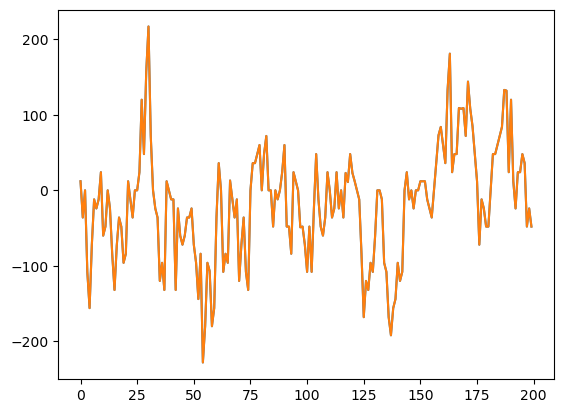

True


In [5]:
# Sanity check that window_to_time works and that recording windows are from correct recording
WINDOW_IDX = 1341231
##
window = rec_windows.windows[WINDOW_IDX].flatten()
time, chan = rec_windows.window_to_time(WINDOW_IDX)
trace = recording.get_traces_raw(start_frame=time, end_frame=time+rec_windows.size_windows, channel_ind=chan).flatten()
plt.plot(window)
plt.plot(trace)
plt.show()
print(np.all(window == trace))

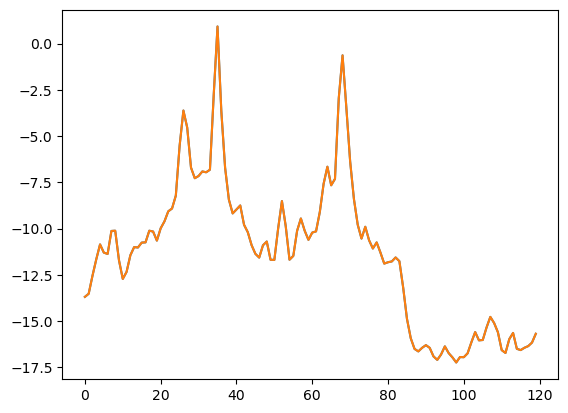

True

In [8]:
# Sanity check model outputs
OUTPUT_IDX = np.random.choice(len(rec_windows))
##
output_saved = rec_windows.outputs[OUTPUT_IDX]
time, chan = rec_windows.window_to_time(OUTPUT_IDX)
trace = recording.get_traces_raw(start_frame=time, end_frame=time+rec_windows.size_windows, channel_ind=chan)
trace = trace - np.mean(trace)
trace = trace / np.std(trace) * 1.38
output_new = model(torch.tensor(trace, dtype=torch.float32, device="cuda"))

plt.plot(output_new.flatten().detach().cpu())
plt.plot(output_saved.flatten())
plt.show()
np.all(np.isclose(output_new.flatten().detach().cpu(), output_saved.flatten()))

In [29]:
output_new.flatten().detach().cpu()

tensor([ -7.7460,  -7.2570,  -6.2292,  -6.9843,  -7.8936,  -9.2138,  -9.1581,
         -8.9758,  -8.9013,  -9.4164,  -9.3796,  -8.3016,  -7.0166,  -9.4583,
         -9.1081,  -6.7758,  -7.3832, -10.5103, -11.9837, -11.7290, -11.8239,
        -11.7789, -10.8843, -11.2038, -11.4496, -12.9048, -14.7498, -14.2599,
        -13.2885, -13.6240, -14.7081, -15.5125, -15.4253, -15.0736, -14.2768,
        -14.0152, -13.8979, -13.4438, -13.2416, -12.9932, -12.8578, -13.6624,
        -13.7115, -13.2553, -13.1762, -14.4255, -14.8311, -14.8462, -14.3471,
        -13.8285, -13.7153, -14.0991, -14.0243, -14.0701, -13.9836, -14.3396,
        -14.4190, -13.4835, -12.1269, -11.6506, -11.2235, -12.4668, -13.6709,
        -13.0397, -11.9125, -11.3055, -10.6138, -11.2554, -12.2303, -13.4494,
        -13.5356, -12.6950, -11.4341, -11.8175, -12.3398, -12.5902, -12.0229,
        -10.8258,  -8.5438,  -7.0723,  -7.3946,  -9.1855, -10.2665, -10.4530,
        -10.4345, -10.2885, -10.2080, -10.0356, -10.0979, -11.29

In [142]:
output_saved.flatten()

memmap([ -8.500719 ,  -6.354083 ,  -4.7953024,  -8.197052 , -10.276018 ,
         -7.7434516,  -4.6499743,  -7.094084 ,  -8.89444  ,  -8.053623 ,
         -8.204606 , -10.241224 , -12.153585 , -12.464762 , -11.626696 ,
        -11.293348 , -12.05574  , -11.524805 ,  -9.145918 ,  -8.017911 ,
        -10.296559 , -10.112625 ,  -7.0724964,  -7.340755 ,  -9.278902 ,
        -10.014323 ,  -9.305616 ,  -8.912401 ,  -9.631702 ,  -7.320527 ,
         -6.742236 ,  -9.983881 ,  -9.657915 ,  -6.109065 ,  -5.1477723,
         -7.430297 ,  -9.18119  ,  -9.272045 ,  -9.569979 , -10.255022 ,
         -9.445064 ,  -8.584811 ,  -8.391308 , -10.140879 ,  -9.739407 ,
         -6.820873 ,  -7.3332787,  -9.092457 ,  -6.6150208,  -4.7654247,
         -6.162134 ,  -7.1930633,  -7.282508 ,  -7.263839 ,  -7.146678 ,
         -6.2468987,  -5.6174054,  -4.8750505,  -6.5142617,  -8.336078 ,
         -8.683981 ,  -8.313318 ,  -8.595451 ,  -7.622609 ,  -6.8846545,
         -8.4750395,  -9.500384 ,  -9.5700035,  -8.

In [46]:
output_saved.shape

(120,)

In [47]:
output_new.shape

torch.Size([1, 120])